In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import gensim

from gensim.models import Word2Vec, KeyedVectors

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
import matplotlib.pyplot as plt
import nltk

from tensorflow.keras.utils import to_categorical

In [2]:
data = pd.read_csv("data/news_class.csv")

df = data.copy() # to be safe and avoid errors

df = df.loc[:,["data_id" , "content" , "category_level_1" , "category_level_2"]]
df.groupby(['category_level_1'])['data_id'].agg('count')

category_level_1
arts, culture, entertainment and media        300
conflict, war and peace                       800
crime, law and justice                        500
disaster, accident and emergency incident     500
economy, business and finance                 400
education                                     607
environment                                   600
health                                        700
human interest                                600
labour                                        703
lifestyle and leisure                         300
politics                                      900
religion and belief                           800
science and technology                        800
society                                      1100
sport                                         907
weather                                       400
Name: data_id, dtype: int64

In [3]:
def labeler(dataframe_column):
    encoder=LabelEncoder()
    
    labels = encoder.fit_transform(dataframe_column)
    print(encoder.classes_)
    print("We did it boys , labels have been created")
    
    return(pd.DataFrame(labels))

In [4]:
# Function for removing ASCII characters
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Function for converting to lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words

def remove_stop_words(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text =  tokenizer.tokenize(text)
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text


# Function for removing html
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

def lemm_text(text):
    lemm=WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    tokens = text
    return ' '.join([lemm.lemmatize(t) for t in tokens])


def remove_digits(text):
    text = re.sub(r'\d', '', text)
    #text = " ".join(text)
    return text

In [5]:
df['Cleaned'] = df['content'].apply(_removeNonAscii)
df['Cleaned'] = df.Cleaned.apply(func = make_lower_case)
df['Cleaned'] = df.Cleaned.apply(func = remove_stop_words)
df['Cleaned'] = df.Cleaned.apply(func = remove_punctuation)
df['Cleaned'] = df.Cleaned.apply(func = remove_html)
df['Cleaned'] = df.Cleaned.apply(func = lemm_text)
df['Cleaned'] = df.Cleaned.apply(func = remove_digits)
df = df.drop('content' , axis =1)

In [6]:
io = df.copy()

io = io.drop([374]).reset_index(drop=True)
io = io.drop([6527]).reset_index(drop=True)

corpus_full = []
for words in io['Cleaned']:
    corpus_full.append(words.split()) 

In [7]:
def vectorizer():
    
    
    # Creating a list for storing the vectors ('Description' into vectors)
    #global word_embeddings
    word_embeddings = []
    i = 0
    # Reading the each 'Description'
    for line in io['Cleaned']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in model.wv.key_to_index:
                count += 1
                if avgword2vec is None:
                    avgword2vec = model.wv[word]
                else:
                    avgword2vec = avgword2vec + model.wv[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
            word_embeddings.append(avgword2vec)
        else:
            print("I found it , the error occurs at line:" , i)
          
        i +=1 

    return(pd.DataFrame(word_embeddings))  # Returning our Data as a Dataframe (aesthetic reasons)

In [8]:
model = Word2Vec(sentences=corpus_full, vector_size=600, window=4, min_count=10, sg = 1 , hs = 1)  # skipgram architecture

In [10]:
model.save("model_4_a_parenthesis.h3")

In [9]:
vect = vectorizer()

In [11]:
y1 = labeler(io["category_level_1"])


X = vect.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2,random_state=42)

y_train1 = to_categorical(y_train)

['arts, culture, entertainment and media' 'conflict, war and peace'
 'crime, law and justice' 'disaster, accident and emergency incident'
 'economy, business and finance' 'education' 'environment' 'health'
 'human interest' 'labour' 'lifestyle and leisure' 'politics'
 'religion and belief' 'science and technology' 'society' 'sport'
 'weather']
We did it boys , labels have been created


In [12]:
y_test1 = to_categorical(y_test)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Flatten , Input , Conv2D , MaxPooling2D , BatchNormalization

In [179]:
fc_input = tf.keras.Input(shape=(600,), name="embs")
x = tf.keras.layers.Dense(200, activation="sigmoid")(fc_input)
#x = tf.keras.activations.swish(x)
x = tf.keras.layers.Dense(360, activation="leaky_relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.activations.swish(x)
fc_out = tf.keras.layers.Dense(17, activation="softmax")(x)

In [180]:
my_model= tf.keras.Model(inputs=fc_input, outputs=fc_out, name="News_Classifier")

In [181]:
my_model.summary()

Model: "News_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embs (InputLayer)           [(None, 600)]             0         
                                                                 
 dense_89 (Dense)            (None, 200)               120200    
                                                                 
 dense_90 (Dense)            (None, 360)               72360     
                                                                 
 dropout_26 (Dropout)        (None, 360)               0         
                                                                 
 dense_91 (Dense)            (None, 17)                6137      
                                                                 
Total params: 198697 (776.16 KB)
Trainable params: 198697 (776.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [182]:
opt = tf.keras.optimizers.AdamW(learning_rate =0.007 , beta_1=0.9,
    beta_2=0.999,
    use_ema=True,
    ema_momentum=0.99)

In [183]:
my_model.compile(optimizer = opt , 
              loss = 'categorical_crossentropy' ,
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

In [184]:
my_model.fit(X_train , y_train1 , batch_size = 16 , epochs = 10 , validation_split=(0.2) ,verbose =1)


predictions = np.argmax(my_model.predict(X_test), axis=-1)

print(predictions)


print(classification_report(y_test.values , predictions))

Epoch 1/10
437/437 [==============================] - 3s 4ms/step - loss: 1.8027 - accuracy: 0.9497 - precision: 0.7122 - recall: 0.2427 - val_loss: 1.3245 - val_accuracy: 0.9569 - val_precision: 0.7577 - val_recall: 0.3921
Epoch 2/10
437/437 [==============================] - 2s 4ms/step - loss: 1.2077 - accuracy: 0.9590 - precision: 0.7413 - recall: 0.4644 - val_loss: 1.2794 - val_accuracy: 0.9601 - val_precision: 0.7385 - val_recall: 0.4980
Epoch 3/10
437/437 [==============================] - 2s 4ms/step - loss: 1.0567 - accuracy: 0.9638 - precision: 0.7739 - recall: 0.5443 - val_loss: 1.1508 - val_accuracy: 0.9643 - val_precision: 0.7528 - val_recall: 0.5856
Epoch 4/10
437/437 [==============================] - 2s 4ms/step - loss: 0.9565 - accuracy: 0.9675 - precision: 0.7967 - recall: 0.6004 - val_loss: 1.1053 - val_accuracy: 0.9639 - val_precision: 0.7511 - val_recall: 0.5770
Epoch 5/10
437/437 [==============================] - 2s 4ms/step - loss: 0.8950 - accuracy: 0.9696 - pr

In [185]:
my_model.fit(X_train , y_train1 , batch_size = 16 , epochs = 10 , validation_split=(0.2) ,verbose =1)


predictions = np.argmax(my_model.predict(X_test), axis=-1)

print(predictions)


print(classification_report(y_test.values , predictions))

Epoch 1/10
437/437 [==============================] - 2s 4ms/step - loss: 0.6613 - accuracy: 0.9763 - precision: 0.8468 - recall: 0.7296 - val_loss: 1.2506 - val_accuracy: 0.9658 - val_precision: 0.7424 - val_recall: 0.6417
Epoch 2/10
437/437 [==============================] - 2s 4ms/step - loss: 0.6440 - accuracy: 0.9770 - precision: 0.8522 - recall: 0.7366 - val_loss: 1.2004 - val_accuracy: 0.9683 - val_precision: 0.7680 - val_recall: 0.6611
Epoch 3/10
437/437 [==============================] - 2s 4ms/step - loss: 0.6256 - accuracy: 0.9776 - precision: 0.8568 - recall: 0.7437 - val_loss: 1.2966 - val_accuracy: 0.9663 - val_precision: 0.7467 - val_recall: 0.6463
Epoch 4/10
437/437 [==============================] - 2s 4ms/step - loss: 0.5815 - accuracy: 0.9791 - precision: 0.8657 - recall: 0.7632 - val_loss: 1.3557 - val_accuracy: 0.9660 - val_precision: 0.7415 - val_recall: 0.6468
Epoch 5/10
437/437 [==============================] - 2s 4ms/step - loss: 0.5512 - accuracy: 0.9805 - pr

In [186]:
#############################################################################################################################

In [190]:
fc_input = tf.keras.Input(shape=(600,), name="embs")
x = tf.keras.layers.Dense(200, activation="gelu")(fc_input)
#x = tf.keras.activations.swish(x)
x = tf.keras.layers.Dense(360, activation="leaky_relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.activations.swish(x)
fc_out = tf.keras.layers.Dense(17, activation="softmax")(x)

In [191]:
my_model2= tf.keras.Model(inputs=fc_input, outputs=fc_out, name="News_Classifier")

In [192]:
opt = tf.keras.optimizers.AdamW(learning_rate =0.007 , beta_1=0.9,
    beta_2=0.999,
    use_ema=True,
    ema_momentum=0.99)





my_model2.compile(optimizer = opt , 
              loss = 'categorical_crossentropy' ,
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])





my_model2.fit(X_train , y_train1 , batch_size = 16 , epochs = 10 , validation_split=(0.2) ,verbose =1)


predictions = np.argmax(my_model2.predict(X_test), axis=-1)

print(predictions)


print(classification_report(y_test.values , predictions))

Epoch 1/10
437/437 [==============================] - 3s 4ms/step - loss: 1.5045 - accuracy: 0.9534 - precision: 0.6876 - recall: 0.3800 - val_loss: 1.4381 - val_accuracy: 0.9560 - val_precision: 0.6730 - val_recall: 0.4888
Epoch 2/10
437/437 [==============================] - 2s 4ms/step - loss: 1.2641 - accuracy: 0.9600 - precision: 0.7316 - recall: 0.5045 - val_loss: 1.2506 - val_accuracy: 0.9619 - val_precision: 0.7667 - val_recall: 0.5060
Epoch 3/10
437/437 [==============================] - 2s 4ms/step - loss: 1.0821 - accuracy: 0.9640 - precision: 0.7585 - recall: 0.5688 - val_loss: 1.3527 - val_accuracy: 0.9593 - val_precision: 0.7125 - val_recall: 0.5163
Epoch 4/10
437/437 [==============================] - 2s 4ms/step - loss: 0.9997 - accuracy: 0.9663 - precision: 0.7724 - recall: 0.6050 - val_loss: 1.1957 - val_accuracy: 0.9646 - val_precision: 0.7758 - val_recall: 0.5604
Epoch 5/10
437/437 [==============================] - 2s 4ms/step - loss: 0.9406 - accuracy: 0.9680 - pr

In [193]:
#############################################################################################################################

In [200]:
fc_input = tf.keras.Input(shape=(600,), name="embs")
x = tf.keras.layers.Dense(200, activation="softplus")(fc_input)
#x = tf.keras.activations.swish(x)
x = tf.keras.layers.Dense(360, activation="leaky_relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.activations.swish(x)
fc_out = tf.keras.layers.Dense(17, activation="softmax")(x)

my_model3= tf.keras.Model(inputs=fc_input, outputs=fc_out, name="News_Classifier")


opt = tf.keras.optimizers.AdamW(learning_rate =0.007 , beta_1=0.9,
    beta_2=0.999,
    use_ema=True,
    ema_momentum=0.99)





my_model3.compile(optimizer = opt , 
              loss = 'categorical_crossentropy' ,
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])





my_model3.fit(X_train , y_train1 , batch_size = 16 , epochs = 10 , validation_split=(0.2) ,verbose =1)


predictions = np.argmax(my_model3.predict(X_test), axis=-1)

print(predictions)


print(classification_report(y_test.values , predictions))

Epoch 1/10
437/437 [==============================] - 3s 5ms/step - loss: 1.8772 - accuracy: 0.9483 - precision: 0.6887 - recall: 0.2210 - val_loss: 1.3498 - val_accuracy: 0.9566 - val_precision: 0.7956 - val_recall: 0.3520
Epoch 2/10
437/437 [==============================] - 2s 4ms/step - loss: 1.2261 - accuracy: 0.9590 - precision: 0.7452 - recall: 0.4594 - val_loss: 1.2958 - val_accuracy: 0.9593 - val_precision: 0.7526 - val_recall: 0.4579
Epoch 3/10
437/437 [==============================] - 2s 4ms/step - loss: 1.0767 - accuracy: 0.9635 - precision: 0.7763 - recall: 0.5340 - val_loss: 1.2136 - val_accuracy: 0.9613 - val_precision: 0.7475 - val_recall: 0.5169
Epoch 4/10
437/437 [==============================] - 2s 4ms/step - loss: 0.9843 - accuracy: 0.9663 - precision: 0.7929 - recall: 0.5772 - val_loss: 1.1505 - val_accuracy: 0.9638 - val_precision: 0.7579 - val_recall: 0.5644
Epoch 5/10
437/437 [==============================] - 2s 4ms/step - loss: 0.9232 - accuracy: 0.9679 - pr

In [231]:
#############################################################################################################################

# THE BEST OF THE BEST LESGOO

In [201]:
y_test1 = to_categorical(y_test , dtype = int)

In [202]:
y_test1

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [229]:
fc_input = tf.keras.Input(shape=(600,), name="embs")
x = tf.keras.layers.Dense(200, activation="leaky_relu")(fc_input)
#x = tf.keras.activations.swish(x)
x = tf.keras.layers.Dense(360, activation="leaky_relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.activations.swish(x)
fc_out = tf.keras.layers.Dense(17, activation="softmax")(x)

my_model3= tf.keras.Model(inputs=fc_input, outputs=fc_out, name="News_Classifier")


opt = tf.keras.optimizers.AdamW(learning_rate =0.007 , beta_1=0.9,
    beta_2=0.999,
    use_ema=True,
    ema_momentum=0.9999)





my_model3.compile(optimizer = opt , 
              loss = 'categorical_crossentropy' ,
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])





my_model3.fit(X_train , y_train1 , batch_size = 16 , epochs = 10 , validation_split=(0.2) ,verbose =1)


predictions = np.argmax(my_model3.predict(X_test), axis=-1)

print(predictions)


print(classification_report(y_test.values , predictions))

Epoch 1/10
437/437 [==============================] - 3s 4ms/step - loss: 1.5388 - accuracy: 0.9537 - precision: 0.6983 - recall: 0.3741 - val_loss: 1.2800 - val_accuracy: 0.9600 - val_precision: 0.7504 - val_recall: 0.4785
Epoch 2/10
437/437 [==============================] - 2s 4ms/step - loss: 1.2314 - accuracy: 0.9608 - precision: 0.7358 - recall: 0.5211 - val_loss: 1.2085 - val_accuracy: 0.9612 - val_precision: 0.7423 - val_recall: 0.5226
Epoch 3/10
437/437 [==============================] - 2s 4ms/step - loss: 1.1424 - accuracy: 0.9632 - precision: 0.7482 - recall: 0.5651 - val_loss: 1.2361 - val_accuracy: 0.9608 - val_precision: 0.7152 - val_recall: 0.5535
Epoch 4/10
437/437 [==============================] - 2s 4ms/step - loss: 1.0405 - accuracy: 0.9661 - precision: 0.7715 - recall: 0.6029 - val_loss: 1.3299 - val_accuracy: 0.9632 - val_precision: 0.7385 - val_recall: 0.5804
Epoch 5/10
437/437 [==============================] - 2s 4ms/step - loss: 1.0124 - accuracy: 0.9672 - pr

In [230]:
#############################################################################################################################

In [237]:
fc_input = tf.keras.Input(shape=(600,), name="embs")
x = tf.keras.layers.Dense(200, activation="leaky_relu")(fc_input)
#x = tf.keras.activations.swish(x)
x = tf.keras.layers.Dense(360, activation="leaky_relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.activations.swish(x)
fc_out = tf.keras.layers.Dense(17, activation="softmax")(x)

my_model6= tf.keras.Model(inputs=fc_input, outputs=fc_out, name="News_Classifier")


opt = tf.keras.optimizers.AdamW(learning_rate =0.007 , beta_1=0.9,
    beta_2=0.999,
    use_ema=True,
    ema_momentum=0.9999,
    weight_decay = 0.0005)





my_model6.compile(optimizer = opt , 
              loss = 'categorical_crossentropy' ,
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])





my_model6.fit(X_train , y_train1 , batch_size = 16 , epochs = 10 , validation_split=(0.2) ,verbose =1)


predictions = np.argmax(my_model6.predict(X_test), axis=-1)

print(predictions)


print(classification_report(y_test.values , predictions))

Epoch 1/10
437/437 [==============================] - 3s 4ms/step - loss: 1.5412 - accuracy: 0.9531 - precision: 0.6889 - recall: 0.3696 - val_loss: 1.3762 - val_accuracy: 0.9590 - val_precision: 0.7272 - val_recall: 0.4837
Epoch 2/10
437/437 [==============================] - 1s 3ms/step - loss: 1.2332 - accuracy: 0.9594 - precision: 0.7222 - recall: 0.5047 - val_loss: 1.6390 - val_accuracy: 0.9524 - val_precision: 0.6296 - val_recall: 0.4631
Epoch 3/10
437/437 [==============================] - 1s 3ms/step - loss: 1.1459 - accuracy: 0.9631 - precision: 0.7472 - recall: 0.5634 - val_loss: 1.2936 - val_accuracy: 0.9621 - val_precision: 0.7478 - val_recall: 0.5363
Epoch 4/10
437/437 [==============================] - 1s 3ms/step - loss: 1.0808 - accuracy: 0.9646 - precision: 0.7531 - recall: 0.5914 - val_loss: 1.3282 - val_accuracy: 0.9598 - val_precision: 0.7025 - val_recall: 0.5501
Epoch 5/10
437/437 [==============================] - 1s 3ms/step - loss: 1.0472 - accuracy: 0.9660 - pr

In [238]:
#############################################################################################################################

In [260]:
fc_input = tf.keras.Input(shape=(600,), name="embs")
x = tf.keras.layers.Dense(200, activation="leaky_relu")(fc_input)
#x = tf.keras.activations.swish(x)
x = tf.keras.layers.Dense(360, activation="leaky_relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.activations.swish(x)
fc_out = tf.keras.layers.Dense(17, activation="softmax")(x)

my_model7= tf.keras.Model(inputs=fc_input, outputs=fc_out, name="News_Classifier")


opt = tf.keras.optimizers.AdamW(learning_rate =0.007 , beta_1=0.9,
    beta_2=0.999,
    use_ema=True,
    ema_momentum=0.9999)





my_model7.compile(optimizer = opt , 
              loss = 'categorical_crossentropy' ,
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])





my_model7.fit(X_train , y_train1 , batch_size = 16 , epochs = 10 , validation_split=(0.2) ,verbose =1)


predictions = np.argmax(my_model7.predict(X_test), axis=-1)

print(predictions)


print(classification_report(y_test.values , predictions))

Epoch 1/10
437/437 [==============================] - 3s 4ms/step - loss: 1.5354 - accuracy: 0.9531 - precision: 0.6893 - recall: 0.3691 - val_loss: 1.3021 - val_accuracy: 0.9590 - val_precision: 0.7092 - val_recall: 0.5123
Epoch 2/10
437/437 [==============================] - 2s 4ms/step - loss: 1.2181 - accuracy: 0.9606 - precision: 0.7325 - recall: 0.5191 - val_loss: 1.2161 - val_accuracy: 0.9623 - val_precision: 0.7411 - val_recall: 0.5507
Epoch 3/10
437/437 [==============================] - 2s 3ms/step - loss: 1.1410 - accuracy: 0.9634 - precision: 0.7490 - recall: 0.5685 - val_loss: 1.4788 - val_accuracy: 0.9581 - val_precision: 0.7106 - val_recall: 0.4848
Epoch 4/10
437/437 [==============================] - 2s 3ms/step - loss: 1.1059 - accuracy: 0.9644 - precision: 0.7544 - recall: 0.5853 - val_loss: 1.2807 - val_accuracy: 0.9626 - val_precision: 0.7232 - val_recall: 0.5907
Epoch 5/10
437/437 [==============================] - 1s 3ms/step - loss: 1.0261 - accuracy: 0.9663 - pr

In [262]:
############################################################################################################################

In [264]:
fc_input = tf.keras.Input(shape=(600,), name="embs")
x = tf.keras.layers.Dense(200, activation="leaky_relu")(fc_input)
#x = tf.keras.activations.swish(x)
x = tf.keras.layers.Dense(360, activation="leaky_relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.activations.swish(x)
fc_out = tf.keras.layers.Dense(17, activation="softmax")(x)

my_model7= tf.keras.Model(inputs=fc_input, outputs=fc_out, name="News_Classifier")


opt = tf.keras.optimizers.AdamW(learning_rate =0.007 , beta_1=0.9,
    beta_2=0.999,
    use_ema=True,
    ema_momentum=0.9999)





my_model7.compile(optimizer = opt , 
              loss = 'categorical_crossentropy' ,
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])





HIST = my_model7.fit(X_train , y_train1 , batch_size = 16 , epochs = 20 , validation_split=(0.2) ,verbose =1)


predictions = np.argmax(my_model7.predict(X_test), axis=-1)

print(predictions)


print(classification_report(y_test.values , predictions))

Epoch 1/20
437/437 [==============================] - 3s 5ms/step - loss: 1.5319 - accuracy: 0.9522 - precision: 0.6732 - recall: 0.3631 - val_loss: 1.2065 - val_accuracy: 0.9616 - val_precision: 0.7452 - val_recall: 0.5289
Epoch 2/20
437/437 [==============================] - 2s 4ms/step - loss: 1.2314 - accuracy: 0.9609 - precision: 0.7380 - recall: 0.5201 - val_loss: 1.3648 - val_accuracy: 0.9608 - val_precision: 0.7378 - val_recall: 0.5186
Epoch 3/20
437/437 [==============================] - 2s 4ms/step - loss: 1.1353 - accuracy: 0.9633 - precision: 0.7503 - recall: 0.5632 - val_loss: 1.3212 - val_accuracy: 0.9621 - val_precision: 0.7354 - val_recall: 0.5552
Epoch 4/20
437/437 [==============================] - 2s 4ms/step - loss: 1.0689 - accuracy: 0.9648 - precision: 0.7551 - recall: 0.5936 - val_loss: 1.2892 - val_accuracy: 0.9631 - val_precision: 0.7192 - val_recall: 0.6113
Epoch 5/20
437/437 [==============================] - 2s 4ms/step - loss: 0.9998 - accuracy: 0.9673 - pr

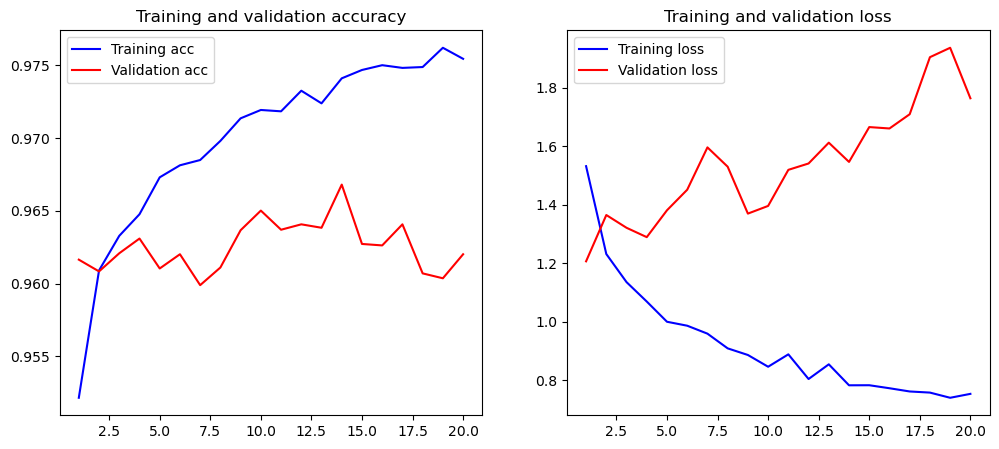

In [265]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    
    
    
plot_history(HIST)